In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import example_utils as ex_utils

import MARBLE
from MARBLE import plotting, dynamics, geometry

# For initial conditions, sample a rectangle uniformly

In [2]:
t0, t1, dt = 0, 3, 0.5
t = np.arange(t0, t1, dt)
n = 100
area = [[-3,-3],[3,3]]

# Geneate phase portraits from random initial conditions while varying $\beta_1$

In [33]:
n_mus = 30
mu = np.hstack((np.linspace(-2, 2, n_mus)))

pos, vel = [], []
X0_range = dynamics.initial_conditions(n, len(mu), area)
for i, m in enumerate(mu):
    p, v = dynamics.simulate_vanderpol(m, X0_range[i], t)
    print(p, np.vstack(p))
    pos.append(np.vstack(p))
    vel.append(np.vstack(v))
    
#embed on parabola
for i, (p, v) in enumerate(zip(pos, vel)):
    end_point = p + v
    new_endpoint = dynamics.parabola(end_point[:,0], end_point[:,1])
    pos[i] = dynamics.parabola(p[:,0], p[:,1])
    vel[i] = new_endpoint - pos[i]

/Users/arnaudon/base/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[array([[ 0.29288102,  1.2911362 ],
       [ 0.69301479,  0.43201286],
       [ 0.78568951, -0.03115783],
       [ 0.68972036, -0.31869981],
       [ 0.50543639, -0.38288051],
       [ 0.33096145, -0.3032371 ]]), array([[ 0.61658026,  0.2692991 ],
       [ 0.65133346, -0.09684672],
       [ 0.55105974, -0.27322063],
       [ 0.40544901, -0.28853602],
       [ 0.2751173 , -0.22726525],
       [ 0.1792765 , -0.15776822]]), array([[-0.4580712 ,  0.87536468],
       [-0.13616669,  0.43316759],
       [ 0.00793418,  0.1733254 ],
       [ 0.05980338,  0.05025403],
       [ 0.06966918, -0.00285742],
       [ 0.06250857, -0.02203673]]), array([[ 0.38543274,  0.87013253],
       [ 0.64048901,  0.22735044],
       [ 0.65807808, -0.1249633 ],
       [ 0.5469219 , -0.28822567],
       [ 0.39698017, -0.29171126]]), array([[ 0.65807808, -0.1249633 ],
       [ 0.5469219 , -0.28822567],
       [ 0.39698017, -0.29171126]]), array([[ 1.75035023,  0.17336952],
       [ 0.46728601, -2.14772202],
       [-

[array([[0.30483588, 0.05043883],
       [0.2924387 , 0.08056163],
       [0.23909292, 0.12199888]]), array([[ 0.29797487, -0.38806564],
       [ 0.14210163, -0.23978573],
       [ 0.05130518, -0.13089615],
       [ 0.00439479, -0.06260021],
       [-0.01614072, -0.0234481 ],
       [-0.02216499, -0.00306682]]), array([[-0.47779319, -1.01799107],
       [-0.80508595, -0.35662602],
       [-0.86496797,  0.10165047],
       [-0.72581033,  0.41825499],
       [-0.49232501,  0.47247589],
       [-0.28187743,  0.35641958]]), array([[-0.8126982 ,  2.64244456],
       [ 0.20191859,  1.32948864],
       [ 0.63361496,  0.50075035],
       [ 0.75932078,  0.03147883],
       [ 0.68987283, -0.28052899]]), array([[-1.20207196, -1.39903635],
       [ 0.63361496,  0.50075035],
       [ 0.75932078,  0.03147883],
       [ 0.68987283, -0.28052899]]), array([[ 0.726803  ,  0.17485257],
       [ 0.71767663, -0.18627909],
       [ 0.57111545, -0.36489393],
       [ 0.38474143, -0.35663619],
       [ 0.2282

[array([[0.29782632, 0.04404975],
       [0.25181862, 0.1274696 ]]), array([[0.29782632, 0.04404975],
       [0.25181862, 0.1274696 ]]), array([[0.25181862, 0.1274696 ]]), array([[ 0.17890417, -0.48715543],
       [-0.01675138, -0.2965481 ],
       [-0.12276049, -0.13472881],
       [-0.1593649 , -0.01974557],
       [-0.15029634,  0.04871621],
       [-0.11718877,  0.07807714]]), array([[-0.9875529 ,  0.73511659],
       [-0.54844463,  0.92004998],
       [-0.14144647,  0.67342248],
       [ 0.11770961,  0.37092836],
       [ 0.24127268,  0.13627858],
       [ 0.26674774, -0.02196012]]), array([[-0.37115144,  1.41529264],
       [ 0.18680642,  0.81706149],
       [ 0.47121837,  0.34769613],
       [ 0.55618415,  0.01055855],
       [ 0.50073963, -0.21147361],
       [ 0.36676405, -0.30295898]]), array([[ 0.10821847,  0.4731516 ],
       [ 0.27021837,  0.18992706],
       [ 0.3127804 , -0.00554594],
       [ 0.27838697, -0.1188996 ],
       [ 0.20585845, -0.16081521],
       [ 0.125953

[array([[0.96301763, 0.45309471],
       [0.64674051, 0.74927153],
       [0.27694218, 0.68210363],
       [0.00946664, 0.45523113]]), array([[ 2.21516724,  0.18513415],
       [-0.81380192, -2.13310634],
       [-1.81936848, -2.21269393]]), array([[-1.60363003, -2.93160717],
       [-0.81380192, -2.13310634],
       [-1.81936848, -2.21269393]]), array([[-0.41718709, -0.58589184],
       [-0.60958061, -0.19455603],
       [-0.62287155,  0.12767901],
       [-0.50057798,  0.33802981],
       [-0.31009342,  0.39976616],
       [-0.12046071,  0.34460487]]), array([[ 0.13604803, -0.12964923],
       [ 0.07135422, -0.12401967],
       [ 0.01582928, -0.09554368],
       [-0.0227715 , -0.05842834],
       [-0.04293865, -0.02320405],
       [-0.04735325,  0.0038839 ]]), array([[ 0.33213884,  0.26031611],
       [ 0.39961274,  0.01999139],
       [ 0.36429971, -0.14744292],
       [ 0.26676221, -0.22821588],
       [ 0.14911985, -0.23145315],
       [ 0.04358944, -0.18500505]]), array([[ 1.5653

[array([[-1.38922573, -2.48701147],
       [ 1.84937916,  0.12945379]]), array([[ 0.80188941,  1.4928233 ],
       [ 1.42527517,  1.03190535],
       [ 1.84778482,  0.64980657],
       [ 2.02949728, -0.02181781],
       [ 0.62053361, -2.37813476]]), array([[-0.00895793, -1.65122013],
       [-0.69788857, -1.10575884],
       [-1.12345921, -0.59881553],
       [-1.28611349, -0.03041524],
       [-1.13538446,  0.63267617],
       [-0.69343107,  1.05837255]]), array([[-0.65778623,  2.65914314],
       [ 0.53487412,  2.0260954 ],
       [ 1.40451366,  1.53270957],
       [ 2.17215245,  1.71245117]]), array([[-1.98533498, -2.46996111],
       [ 1.40451366,  1.53270957],
       [ 2.17215245,  1.71245117]]), array([[1.11215891, 2.72036008],
       [1.40451366, 1.53270957],
       [2.17215245, 1.71245117]]), array([], shape=(0, 2), dtype=float64), array([[ 1.87572577,  0.6751564 ],
       [ 2.07875773,  0.04069498],
       [ 0.67189715, -2.50188019],
       [-0.45785481, -1.92397255],
       [

[array([[ 1.66621446, -1.57475268],
       [ 0.66689263, -2.26432062],
       [-0.45175062, -2.11002278],
       [-1.39069645, -1.62408853],
       [-2.05958399, -1.02779497],
       [-2.37344307, -0.15611716]]), array([[ 1.9456712 ,  2.79449519],
       [-2.05958399, -1.02779497],
       [-2.37344307, -0.15611716]]), array([[-2.43400582, -2.88805049]]), array([[ 0.65425478,  1.65315909],
       [ 1.36056491,  1.14714532],
       [ 1.7746509 ,  0.47546917],
       [ 1.79626147, -0.42631598],
       [ 1.33843733, -1.36949582],
       [ 0.51109302, -1.8264075 ]]), array([[ 0.84968007,  1.33210938],
       [ 1.3871198 ,  0.7922312 ],
       [ 1.61414684,  0.08620852],
       [ 1.45092072, -0.74307161],
       [ 0.90098753, -1.39111094],
       [ 0.14440973, -1.54941121]]), array([[-2.78978086, -1.20930317]]), array([], shape=(0, 2), dtype=float64), array([[-0.76287583,  1.07908771],
       [-0.1715436 ,  1.22361121],
       [ 0.4066394 ,  1.04645847],
       [ 0.84256222,  0.67277077],
  

[array([[ 0.90224545,  0.03272024],
       [ 0.80581011, -0.416231  ],
       [ 0.49114095, -0.83599367],
       [-0.01995446, -1.18887435],
       [-0.65599067, -1.283626  ],
       [-1.20929382, -0.83583597]]), array([[ 2.27160883, -1.90895865],
       [ 1.38816512, -1.79263692],
       [ 0.37841829, -2.31095708],
       [-0.91011182, -2.67859561],
       [-2.22296384,  0.16738784]]), array([[ 2.38222549, -0.18505964],
       [ 2.11339416, -0.79460372],
       [ 1.62706051, -1.14588495],
       [ 0.95421708, -1.57153092],
       [ 0.02901889, -2.13611935]]), array([[ 0.99661   ,  2.92737269],
       [ 2.3233191 , -0.24937882],
       [ 2.03396756, -0.82612567],
       [ 1.529665  , -1.18987585],
       [ 0.82827569, -1.64284403]]), array([[-1.45818946, -2.83016445],
       [-2.33871128,  0.49867761],
       [-1.96905004,  0.93298788],
       [-1.41763219,  1.28303228],
       [-0.66291063,  1.76599524]]), array([[ 0.81431469,  2.08387432],
       [ 1.68029865,  1.18252843],
       [ 

[array([[ 2.0977981 ,  0.0118086 ],
       [ 1.94937267, -0.47051764],
       [ 1.67169366, -0.63542382],
       [ 1.30427059, -0.85611621]]), array([[ 1.59275856, -1.30562494],
       [ 0.94048174, -1.45294031],
       [-0.00613955, -2.49299556],
       [-2.07489845, -0.12815458],
       [-1.95261159,  0.45186364]]), array([[-1.67372782,  1.11733251],
       [-1.12599335,  1.18662126],
       [-0.38317064,  1.91387122],
       [ 2.00372877, -0.32866668]]), array([[-1.99478113,  0.36431306],
       [-1.75016749,  0.58479855],
       [-1.41213817,  0.78115605],
       [-0.94039793,  1.15454029],
       [-0.17510305,  2.02578633]]), array([[ 0.70831408, -0.52841943],
       [ 0.30105818, -1.14273223],
       [-0.48050458, -1.97809366],
       [-1.78090657, -0.00633099],
       [-1.62935715,  0.51754939]]), array([[-2.5751284 ,  0.42236871],
       [-2.3690561 ,  0.422809  ],
       [-2.14518378,  0.47668429],
       [-1.88769932,  0.55938207],
       [-1.57695344,  0.69645431]]), array([

# Plot vector fields

In [4]:
data = MARBLE.construct_dataset(pos, features=vel, graph_type='cknn', k=20, stop_crit=0.03, vector=True)

---- Embedding dimension: 3
---- Signal dimension: 3



Computing tangent spaces...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 603.10it/s]



Fraction of variance explained:  tensor([0.5899, 1.0000, 1.0000])

---- Manifold dimension: 2


Computing connections...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 160.27it/s]



---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 


In [5]:
#titles = [r'$\beta$ = {:0.2f}'.format(m) for m in mu]

#axes = plotting.fields(data, col=4, alpha=1, width=7, scale=2, titles=titles, view=[70,20])
#for ax in axes:
#    ex_utils.plot_parabola(ax)

#plt.savefig('./outputs/parabolas.svg')

# Train network

In [6]:
par = {'epochs': 50, #optimisation epochs
       'order': 2, #order of derivatives
       'hidden_channels': 32, #number of internal dimensions in MLP
       'out_channels': 5,
       'inner_product_features': True,
      }

model = MARBLE.net(data, par=par)
model.run_training(data, outdir='./output/vanderpol_data')
#model.load_model('./outputs/vanderpol_data/best_model.pth')


---- Settings: 

epochs : 50
order : 2
hidden_channels : 32
out_channels : 5
inner_product_features : True
batch_size : 64
lr : 0.01
momentum : 0.9
diffusion : False
include_positions : False
frac_sampled_nb : -1
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 3
dim_emb : 3
dim_man : 2
n_sampled_nb : -1

---- Number of features to pass to the MLP:  7
---- Total number of parameters:  450

---- Training network ...

Epoch: 1, Training loss: 1.361263, Validation loss: 1.3600, lr: 0.0100 *
Epoch: 2, Training loss: 1.340509, Validation loss: 1.3542, lr: 0.0100 *
Epoch: 3, Training loss: 1.329865, Validation loss: 1.2786, lr: 0.0100 *
Epoch: 4, Training loss: 1.302745, Validation loss: 1.2924, lr: 0.0100
Epoch: 5, Training loss: 1.296876, Validation loss: 1.3219, lr: 0.0100
Epoch: 6, Training loss: 1.306161, Validation loss: 1.3103, lr: 0.0100
Epoch: 7, Training loss: 1.294730, Validation loss: 1.2754, lr: 0.0100 *
Epoch: 8,

In [29]:
data = model.evaluate(data)
data = MARBLE.cluster_embeddings(data)

Performed umap embedding on embedded results.


Performed umap embedding on embedded results.


<Axes: >

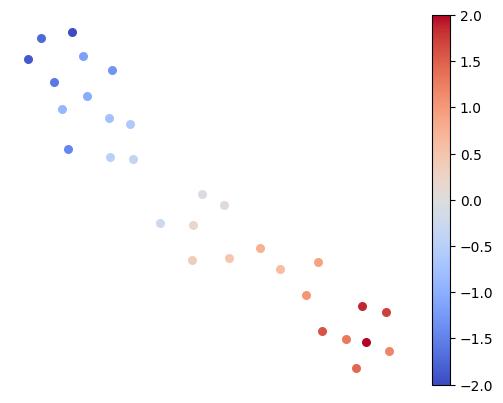

In [30]:
emb_MDS, _ = geometry.embed(data.dist)
plotting.embedding(emb_MDS, mu, s=30, alpha=1)

# Distance matrix

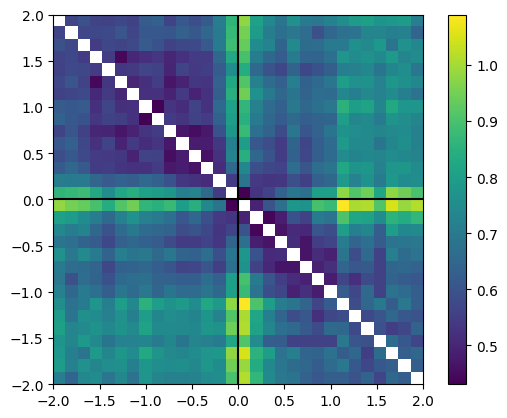

In [31]:
d= data.dist.copy()
d += np.diag(np.diag(d)*np.nan)
im = plt.imshow(d, extent=[mu[0], mu[-1], mu[0], mu[-1]])
plt.axhline(0, c='k')
plt.axvline(0, c='k')

plt.colorbar(im)

# Cluster and visualise embedding

<Axes: >

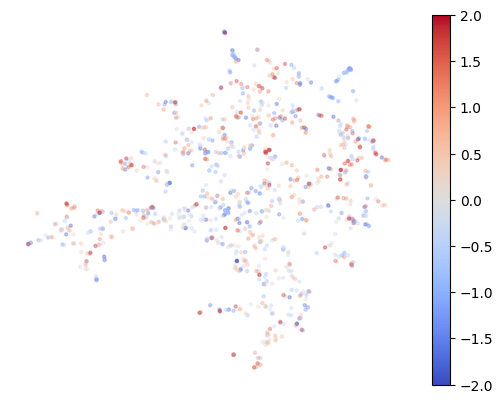

In [32]:
titles = [r'$\beta$ = {:0.2f}'.format(m) for m in mu]
plotting.embedding(data, mu[data.y.numpy().astype(int)])#, titles=titles)